We start by importing the necessary libraries and defining paths to the files we’ll be working with. But before doing anything, we need the EEG data to work with. Use the ds003846-1.0.0.sh script to download the data (will be saved ds003846-1.0.0 folder in the repo). The dataset is organized into folders by subject, with each folder containing sessions for different conditions. We’ll start with subject 1 (sub-1) in the EMS condition.

In [ ]:
# Import necessary libraries
import mne
import pandas as pd
from pathlib import Path
import numpy as np
import os

base_path = Path("./ds003846-1.0.0")
subject = "sub-1"
session = "ses-TestEMS"
data_path = base_path / subject / session / "eeg"

# Define filenames
vhdr_file = data_path / f"{subject}_{session}_task-PredError_eeg.vhdr"
events_file = data_path / f"{subject}_{session}_task-PredError_events.tsv"
channels_file = data_path / f"{subject}_{session}_task-PredError_channels.tsv"

# Ensure paths are correct
if not vhdr_file.exists() or not events_file.exists() or not channels_file.exists():
    raise FileNotFoundError("One or more required files are missing. Please check your dataset structure.")


ModuleNotFoundError: No module named 'np'

Now that the paths are set, we can load the EEG data.

In [ ]:
# Load the EEG Data for subject 1
raw = mne.io.read_raw_brainvision(str(vhdr_file), preload=True)
print(raw.info)
# print(raw.info["ch_names"])
# First, we load the channel metadata (from the channels.tsv file) to understand the details of the data.
channels_df = pd.read_csv(channels_file, sep="\t")
print("Channel Info:")
print(channels_df.head())

Extracting parameters from ds003846-1.0.0/sub-1/ses-TestEMS/eeg/sub-1_ses-TestEMS_task-PredError_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 258029  =      0.000 ...   516.064 secs...
<Info | 7 non-empty values
 bads: []
 ch_names: BrainVision RDA_Fp1, BrainVision RDA_Fp2, BrainVision RDA_F7, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
>
Channel Info:
                  name type       units  sampling_frequency
0  BrainVision RDA_Fp1  EEG  microvolts          499.993768
1  BrainVision RDA_Fp2  EEG  microvolts          499.993768
2   BrainVision RDA_F7  EEG  microvolts          499.993768
3   BrainVision RDA_F3  EEG  microvolts          499.993768
4   BrainVision RDA_Fz  EEG  microvolts          499.993768


The dataset includes channel names like BrainVision RDA_Fp1, which are not directly recognized by MNE’s standard montages. We’ll first remove the prefix BrainVision RDA_ to make the channel names compatible with the 10-20 system, then apply the montage.

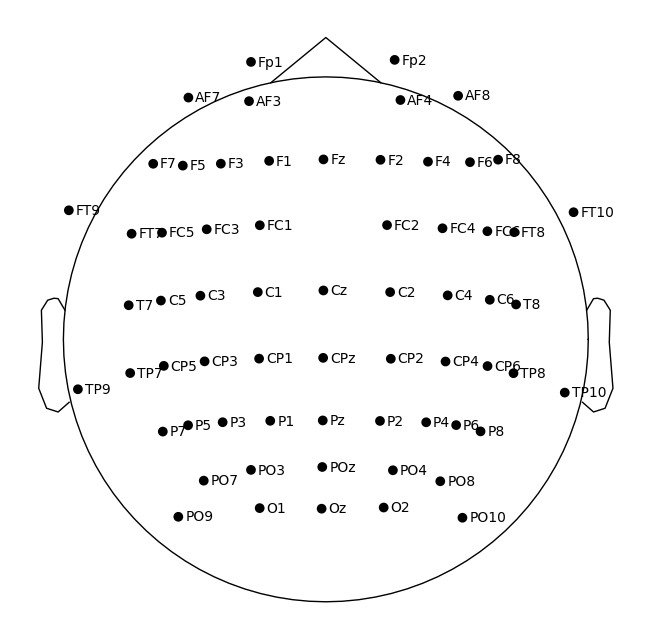

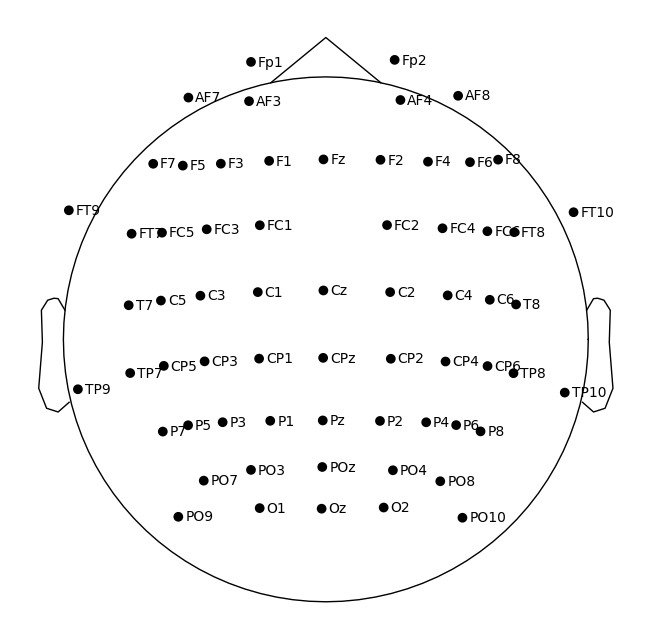

In [ ]:

# The channel names in the dataset have a prefix ("BrainVision RDA_") that is specific to the recording system.
# We need to remove this prefix to match the standard EEG channel naming convention (e.g., "Fp1", "Fz")
raw.rename_channels(lambda x: x.replace("BrainVision RDA_", ""))

# Map Channels to Scalp Positions
montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage)

raw.plot_sensors(kind="topomap", show_names=True)

Next, we filter the data to keep only the 1 Hz to 125 Hz range. This aligns with the filtering step in their paper.

In [ ]:
# let's first check the frequency range of the data before bandpass
# psd, freqs = raw.compute_psd().get_data(return_freqs=True)
# max_freq = freqs.max()
# min_freq = freqs.min()
# print(f"Frequency range in the data: {min_freq} Hz to {max_freq} Hz"
# Filter the Data (1–125 Hz bandpass)
raw.filter(l_freq=1, h_freq=240)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 2.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 240.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 245.00 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


<RawBrainVision | sub-1_ses-TestEMS_task-PredError_eeg.eeg, 64 x 258030 (516.1 s), ~126.1 MB, data loaded>

The data is initially referenced to a specific electrode during recording, but their pipeline specifies re-referencing to the average of all electrodes, including FCz, so we do this next. 

In [ ]:
# Re-reference the data to the average
raw.set_eeg_reference("average")

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawBrainVision | sub-1_ses-TestEMS_task-PredError_eeg.eeg, 64 x 258030 (516.1 s), ~126.1 MB, data loaded>

Their MATLAB pipeline also includes parsing and cleaning event markers, which is handled in the parse_events_PredError function. Here, we replicate that process. First, we load the event markers from the .tsv file into a DataFrame for inspection. Then, we map specific events like box:spawned and box:touched to numerical IDs, converting the event data into a format MNE can use.

In [ ]:
# Load the events file
events_df = pd.read_csv(events_file, sep="\t")
print("Events Info:")
print(events_df.head())

# Map events to MNE format
event_id = {"box:spawned": 1, "box:touched": 2}
events = []

for _, row in events_df.iterrows():
    if row["value"] in event_id:
        sample = int(row["sample"])
        events.append([sample, 0, event_id[row["value"]]])

events = np.array(events)
print("Parsed events:", events)


Events Info:
      onset  duration  sample     type              value
0  0.186002         0      94  Markers        block:start
1  2.408030         0    1205  Markers        box:spawned
2  3.356042         0    1679  Markers    duplicate_event
3  3.360042         0    1681  Markers        box:touched
4  3.470043         0    1736  Markers  vibroFeedback:off


NameError: name 'np' is not defined

Once the events are ready, we create epochs around these markers. This step segments the continuous EEG data into trials, each aligned to specific events of interest. We define the time window as 500 ms before to 1 second after each event, following their pipeline’s approach to stimulus-aligned epoching.